In [42]:
from cn_tools.data_processing import merge_measurements
from cn_tools.data_processing import prepare_df
from cn_tools.data_processing import feature_lists, features

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
import pandas as pd
import os
from itertools import chain


In [79]:
directory = '../Data/final/VF_006_analysis/'
df = merge_measurements(directory)
print(df.shape[0])
df = prepare_df(df, scale_and_split=False)
print(df.shape[0])
x_train, x_test, y_train, y_test = prepare_df(df, scale_and_split = True)
#old_features = ['min_fun', 'curv_cen']#, 'aniso', 'com', 'min_ev']
#feature_list = [feature_lists[key] for key in old_features]
#feature_list = list(chain.from_iterable(feature_list))

feature_list = ['lpf']
#n_input = len(feature_list)
#n_output = y_train.max() - y_train.min() + 1



100%|████████████████████████████████████████████████████████████████████| 78/78 [00:06<00:00, 12.17it/s]


707946
390190


In [59]:
df = pd.read_csv('../Data/old/dataset_2.csv')
res = 20

x_mean = df.x.mean()
y_mean = df.y.mean()
df['r'] = np.sqrt(np.square(df.x-x_mean)+np.square(df.y - y_mean))
#r_min, r_max, z_min, z_max
bounds = {20:[30, 200, 100, 400], 
          30:[45, 300, 135, 600]}
r_min, r_max, z_min, z_max = bounds[res]

mask1 = df.r < r_max
mask2 = df.r > r_min

mask3 = df.z < z_max
mask4 = df.z > z_min

mask5 = df.lpf < 0.74

mask = np.all([mask1, mask2, mask3, mask4, mask5], axis = 0)
df = df[mask]
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
old_features = ['min_fun', 'curv_cen', 'aniso', 'com']
feature_list = [feature_lists[key] for key in old_features]
feature_list = list(chain.from_iterable(feature_list)) + [i[:-3]+'v'+i[-3:] for i in feature_lists['min_ev']]
#x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(scaler.fit_transform(df[feature_list]), columns=feature_list),
#                                                    df.contact_number-df.contact_number.min(), test_size = 0.1,random_state = 42)
old_df = df

In [24]:
def ff_model(n_input, n_output, hidden_dims = (48,38,12), dropout = 0):

    input_layer = ks.layers.Input(shape=(n_input,))
             
    layer1 = ks.layers.Dense(units = hidden_dims[0], activation = 'relu')(input_layer)
    if dropout:
        layer1 = ks.layers.Dropout(dropout)(layer1)
             
    
    layer2 = ks.layers.Dense(units = hidden_dims[1], activation = 'relu')(layer1)
    if dropout:
        layer2 = ks.layers.Dropout(dropout)(layer2)
             
             
    layer3 = ks.layers.Dense(units = hidden_dims[2], activation = 'relu')(layer2)
    if dropout:
        layer3 = ks.layers.Dropout(dropout)(layer3)

    output = ks.layers.Dense(units = n_output, activation = 'softmax')(layer2)
    
    return ks.models.Model(inputs = input_layer, outputs = output)
             
model = ff_model(n_input, n_output, dropout=0.1)
#model.summary()

In [25]:
model.compile(optimizer = ks.optimizers.Adam(epsilon=1e-7), 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

history8 = model.fit(x_train[feature_list].values, y_train, 
          batch_size=128, 
          epochs=30, 
          verbose = 1,
          validation_data = (x_test[feature_list].values, y_test), 
          use_multiprocessing=True)

Epoch 1/30
1172/1172 [==============================] - 3s 3ms/step - loss: 1.4676 - sparse_categorical_accuracy: 0.3503 - val_loss: 1.3816 - val_sparse_categorical_accuracy: 0.3804
Epoch 2/30
1172/1172 [==============================] - 3s 2ms/step - loss: 1.3829 - sparse_categorical_accuracy: 0.3808 - val_loss: 1.3549 - val_sparse_categorical_accuracy: 0.3952
Epoch 3/30
1172/1172 [==============================] - 3s 2ms/step - loss: 1.3645 - sparse_categorical_accuracy: 0.3890 - val_loss: 1.3496 - val_sparse_categorical_accuracy: 0.3949
Epoch 4/30
1172/1172 [==============================] - 3s 2ms/step - loss: 1.3565 - sparse_categorical_accuracy: 0.3937 - val_loss: 1.3362 - val_sparse_categorical_accuracy: 0.4015
Epoch 5/30
1172/1172 [==============================] - 3s 2ms/step - loss: 1.3510 - sparse_categorical_accuracy: 0.3958 - val_loss: 1.3359 - val_sparse_categorical_accuracy: 0.4019
Epoch 6/30
1172/1172 [==============================] - 3s 2ms/step - loss: 1.3461 - spars

KeyboardInterrupt: 

In [63]:
from sklearn.linear_model import LogisticRegression
lre = LogisticRegression(solver = 'saga', n_jobs = 16, max_iter=1000)
lre.fit(x_train[feature_list], y_train)

LogisticRegression(max_iter=1000, n_jobs=16, solver='saga')

In [64]:
lre.score(x_test[feature_list], y_test)

0.3524910157966855

In [56]:
def makse(x, round_numbers = False):
    values = 2*np.sqrt(3)*x/(1-x)
    if round_numbers: 
        return values.round().astype(int)
    else:
        return values
            

comp = makse(df.lpf, round_numbers=True) == df.contact_number.values
comp.sum()/comp.shape[0]



0.3364950408775212

In [47]:
from collections import Counter, OrderedDict
new_dist = Counter(df.contact_number)
new_dist = {i[0]:i[1]/df.shape[0] for i in new_dist.items()}
new_dist = OrderedDict(sorted(new_dist.items()))
old_dist = Counter(old_df.contact_number)
old_dist = {i[0]:i[1]/old_df.shape[0] for i in old_dist.items()}
old_dist = OrderedDict(sorted(old_dist.items()))

5.234134652348856


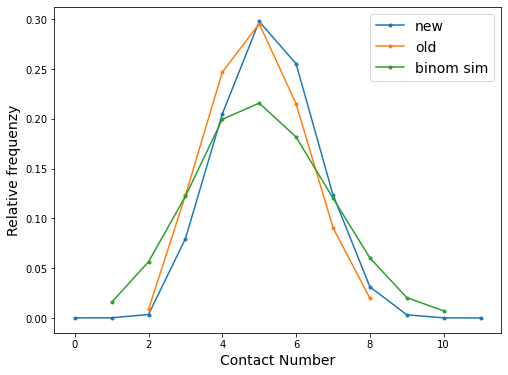

In [54]:
z_values = range(1,12)
plt.figure(figsize = (8,6))
plt.plot(list(new_dist.keys()), list(new_dist.values()), label = 'new', marker = '.')
plt.plot(list(old_dist.keys()), list(old_dist.values()), label = 'old', marker = '.')

n = df.nn.mean()
p = df.contact_number.mean()/n
print(n*p)
data = np.random.binomial(n=n, p=p, size=10000)
data, bin_edges = np.histogram(data, bins = z_values, density = True)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.xlabel('Contact Number', fontsize = 14)
plt.ylabel('Relative frequenzy', fontsize = 14)
plt.plot(z_values[:-1], data, label = 'binom sim', marker = '.')
plt.legend(fontsize = 14)
plt.savefig('distributions.pdf')

In [36]:
old_df.contact_number.mean(), df.contact_number.mean()

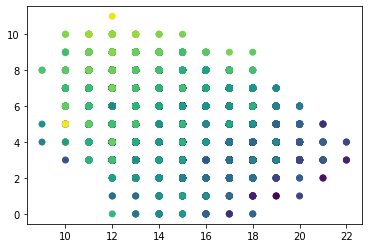

In [80]:
plt.scatter(df.nn, df.contact_number, c = df.lpf)

In [75]:
data, bin_edges = np.histogram(df.z, bins = 50, density = True)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

output = rectangel.fit(data, x = bin_centers)
plt.plot(bin_centers, output.best_fit)

In [59]:
df.z.max(), df.z.min(), df.r.max(), df.r.min()
#from cn_tools.cns_fit import approximate_diameter
#approximate_diamnp.array(old_dist.values())eter('../Data/final/VF_008_analysis/tomo_gray_SUB_008_004.csv')


In [83]:

min_fun = df.columns[:4].tolist()
min_ev = df.columns[16:34].tolist()
imt = df.columns[38:52].tolist()
com = [i for i in df.columns if 'com' in i]
curv_cen = [i for i in df.columns if 'cc' in i]
custom = ['nn', 'lpf']
old_features
features = min_fun + min_ev + imt + com + curv_cen + custom
scaler = StandardScaler()
df_x  = scaler.fit_transform(df[features])
#df_x = pd.DataFrame(scaler.fit_transform(df_cut[features]), columns = features)
df_y = df_cut.contact_number
df_x

NameError: name 'StandardScaler' is not defined

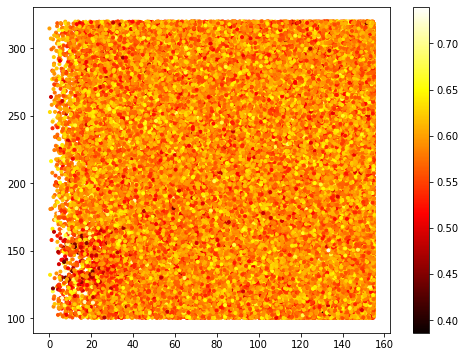

In [78]:
old = pd.read_csv('/home/ansgar/Documents/Master_Thesis/Data/Datasets/dataset_1.csv')
plt.figure(figsize = (8,6))
x_mean = old.x.mean()
y_mean = old.y.mean()
old['r'] = np.sqrt(np.square(old.x-x_mean)+np.square(old.y - y_mean))
plt.scatter(old.r, old.z, c = old.lpf, cmap = 'hot', marker = '.')
plt.colorbar()
plt.show()

In [73]:
old.columns

Index(['Unnamed: 0', 'label', 'contact_number', 'x', 'y', 'z', 'lpf',
       'volume_cell', 'volume_particle', 'w000', 'w010_x', 'w010_y', 'w010_z',
       'w020_eigsysvEv1', 'w020_eigsysvEv1x', 'w020_eigsysvEv1y',
       'w020_eigsysvEv1z', 'w020_eigsysvEv2', 'w020_eigsysvEv2x',
       'w020_eigsysvEv2y', 'w020_eigsysvEv2z', 'w020_eigsysvEv3',
       'w020_eigsysvEv3x', 'w020_eigsysvEv3y', 'w020_eigsysvEv3z', 'w100',
       'w102_eigsysvEv1', 'w102_eigsysvEv1x', 'w102_eigsysvEv1y',
       'w102_eigsysvEv1z', 'w102_eigsysvEv2', 'w102_eigsysvEv2x',
       'w102_eigsysvEv2y', 'w102_eigsysvEv2z', 'w102_eigsysvEv3',
       'w102_eigsysvEv3x', 'w102_eigsysvEv3y', 'w102_eigsysvEv3z', 'w110_x',
       'w110_y', 'w110_z', 'w120_eigsysvEv1', 'w120_eigsysvEv1x',
       'w120_eigsysvEv1y', 'w120_eigsysvEv1z', 'w120_eigsysvEv2',
       'w120_eigsysvEv2x', 'w120_eigsysvEv2y', 'w120_eigsysvEv2z',
       'w120_eigsysvEv3', 'w120_eigsysvEv3x', 'w120_eigsysvEv3y',
       'w120_eigsysvEv3z', 'w200', 'w2